In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [79]:
initial_data = pd.read_excel('data/initial_data.xlsx')

In [97]:
initial_data.head(2)

,ADDRESS,CITY,REGION,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly,Avg_check
0,"г.Калуга, Литейная ул., 25/15",калуга,Калужская область,NaN,3.3,NaN,13.0,1.0,7696.0,10099,3382,324698,0,0,0.0,1,423321,2.986103
1,"г.Калуга, Гагарина ул., 1",калуга,Калужская область,NaN,NaN,NaN,NaN,NaN,6369.0,10068,3236,324698,1,1,0.0,1,423321,3.111248


In [83]:
initial_data.drop('Unnamed: 0', axis=1, inplace=True)

In [84]:
initial_data['NEAR_metro_rjd'].fillna(0, inplace=True)

In [85]:
renamer = {np.nan:0, 'автостанция':1, 'остановка':1}
initial_data['NEAR_Stations'] = initial_data['NEAR_Stations'].map(renamer)

In [86]:
initial_data['Avg_check'] = initial_data['value1'] / initial_data['value2']

In [87]:
initial_data.describe()

,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly,Avg_check
count,72.000000,153.000000,72.000000,153.000000,140.000000,416.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,2.416667,1.362745,0.347222,7.156863,0.892857,2551.600962,10006.038369,2808.601918,147402.803357,0.103118,0.035971,0.023981,0.220624,404089.705036,3.579314
std,1.275445,0.899699,0.479428,3.509606,0.310405,1963.959893,57.084102,202.017409,175342.903452,0.304478,0.186442,0.153173,0.415165,17786.448797,0.233648
min,1.000000,0.200000,0.000000,1.000000,0.000000,0.000000,9911.000000,2231.000000,119.000000,0.000000,0.000000,0.000000,0.000000,387679.000000,2.898967
25%,2.000000,0.700000,0.000000,5.000000,1.000000,1001.500000,9956.000000,2670.000000,11288.000000,0.000000,0.000000,0.000000,0.000000,387679.000000,3.438011
50%,2.000000,1.200000,0.000000,7.000000,1.000000,2165.000000,9999.000000,2781.000000,55282.000000,0.000000,0.000000,0.000000,0.000000,387679.000000,3.593627
75%,3.000000,1.900000,1.000000,9.000000,1.000000,3558.750000,10056.000000,2928.000000,324698.000000,0.000000,0.000000,0.000000,0.000000,423321.000000,3.731360
max,7.000000,4.800000,1.000000,19.000000,1.000000,9775.000000,10100.000000,3484.000000,482873.000000,1.000000,1.000000,1.000000,1.000000,423321.000000,4.442403


In [88]:
initial_data['CITY'] = [w.lower() for w in initial_data['CITY']]

In [89]:
initial_data.head()

,ADDRESS,CITY,REGION,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly,Avg_check
0,"г.Калуга, Литейная ул., 25/15",калуга,Калужская область,NaN,3.3,NaN,13.0,1.0,7696.0,10099,3382,324698,0,0,0.0,1,423321,2.986103
1,"г.Калуга, Гагарина ул., 1",калуга,Калужская область,NaN,NaN,NaN,NaN,NaN,6369.0,10068,3236,324698,1,1,0.0,1,423321,3.111248
2,"г.Калуга, Кибальчича ул., 25",калуга,Калужская область,NaN,3.1,NaN,12.0,1.0,5553.0,10100,3436,324698,1,0,0.0,0,423321,2.939464
3,"г.Калуга, Пестеля ул., 60/49",калуга,Калужская область,3.0,2.2,0.0,12.0,1.0,7162.0,10099,3257,324698,0,0,0.0,0,423321,3.100706
4,"г.Калуга, Ленина ул., 81",калуга,Калужская область,1.0,2.0,0.0,9.0,1.0,6269.0,10096,3195,324698,1,0,0.0,1,423321,3.159937


In [90]:
city_lens = sorted(dict(Counter(initial_data['CITY'])).values())

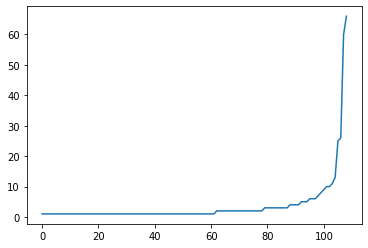

In [91]:
plt.plot(city_lens)


---



In [92]:
initial_data.columns

Index(['ADDRESS', 'CITY', 'REGION', 'Postamat_daily', 'cashbox_daily',
       'Postamat_trend', 'cashbox_MAX', 'cashbox_trend', 'hh_500', 'value1',
       'value2', 'POPULATION', 'NEAR_Malls', 'NEAR_Business_centers',
       'NEAR_metro_rjd', 'NEAR_Stations', 'macro_salary_avg_yearly',
       'Avg_check'],
      dtype='object')

In [93]:
correl_data = initial_data.drop(['ADDRESS', 'CITY', 'REGION'], axis=1)

In [94]:
correl_data.fillna(0, inplace=True)

In [95]:
correl_data.corr()

,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly,Avg_check
Postamat_daily,1.000000,0.177760,0.570814,0.141102,0.118381,0.328722,0.221891,0.307903,0.412641,0.150038,0.009052,-0.002567,0.135019,-0.009653,-0.302617
cashbox_daily,0.177760,1.000000,0.154076,0.929547,0.760902,0.360884,0.193851,0.315590,0.164636,0.150807,0.176779,-0.047817,0.147919,0.348295,-0.312489
Postamat_trend,0.570814,0.154076,1.000000,0.138123,0.121398,0.261340,0.120306,0.144580,0.281976,0.047236,0.059709,-0.039585,0.133603,0.009915,-0.148214
cashbox_MAX,0.141102,0.929547,0.138123,1.000000,0.827207,0.340020,0.144420,0.272420,0.122561,0.085877,0.071930,-0.047468,0.133455,0.336141,-0.273979
cashbox_trend,0.118381,0.760902,0.121398,0.827207,1.000000,0.281999,0.142131,0.238884,0.063874,0.036322,-0.013953,-0.068344,0.081064,0.309225,-0.242877
hh_500,0.328722,0.360884,0.261340,0.340020,0.281999,1.000000,0.196850,0.449110,0.522211,0.223836,0.209819,-0.050834,0.236225,-0.057816,-0.456262
value1,0.221891,0.193851,0.120306,0.144420,0.142131,0.196850,1.000000,0.858173,0.057709,0.146651,0.042784,-0.096878,0.086568,0.217176,-0.840725
value2,0.307903,0.315590,0.144580,0.272420,0.238884,0.449110,0.858173,1.000000,0.230480,0.286896,0.108816,-0.037989,0.226099,0.094721,-0.994494
POPULATION,0.412641,0.164636,0.281976,0.122561,0.063874,0.522211,0.057709,0.230480,1.000000,0.242024,0.146433,0.013052,0.419904,-0.076702,-0.231987
NEAR_Malls,0.150038,0.150807,0.047236,0.085877,0.036322,0.223836,0.146651,0.286896,0.242024,1.000000,0.188575,-0.001607,0.237957,-0.075916,-0.283992


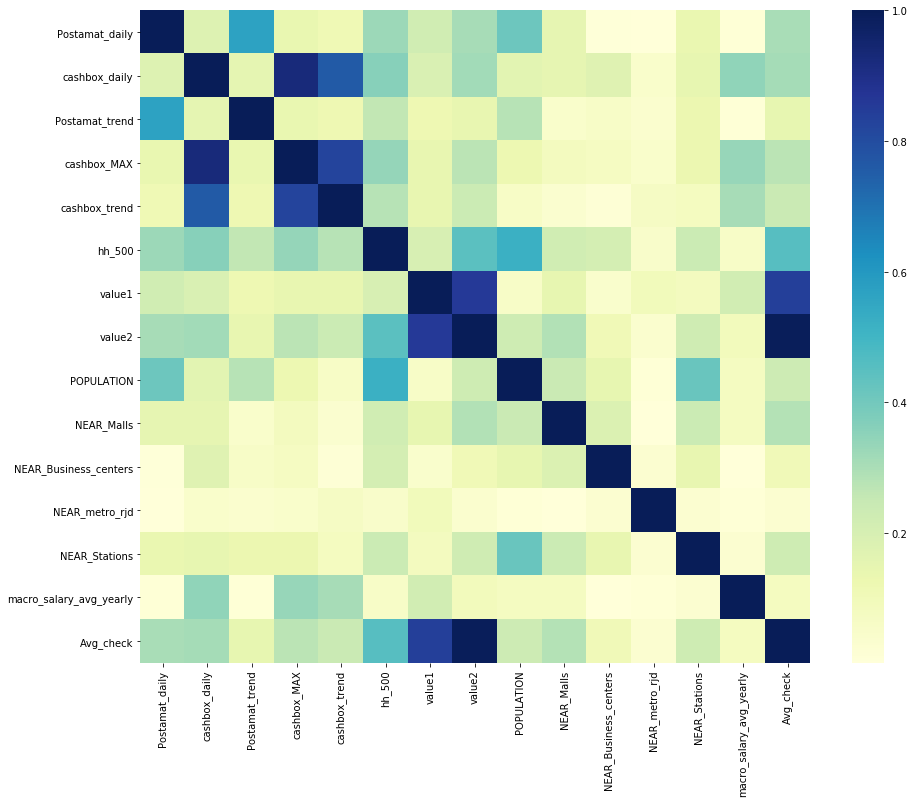

In [96]:
fig = plt.figure(figsize=(15, 12)) 
ax = plt.subplot()
ax = sns.heatmap(abs(correl_data.corr()), cmap="YlGnBu")